In [1]:
from foobah.gcode import GCODE
from foobah.utils import preview_png
from foobah.methods import line_threshold
from foobah import constants
from foobah.constants import XMAX, XMIN, YMAX, YMIN

import PIL
import PIL.Image
import PIL.ImageFilter

import math
import numpy as np

import random
from random import uniform
from scipy.spatial import Delaunay, KDTree

from collections import defaultdict
from operator import itemgetter

from IPython.display import display

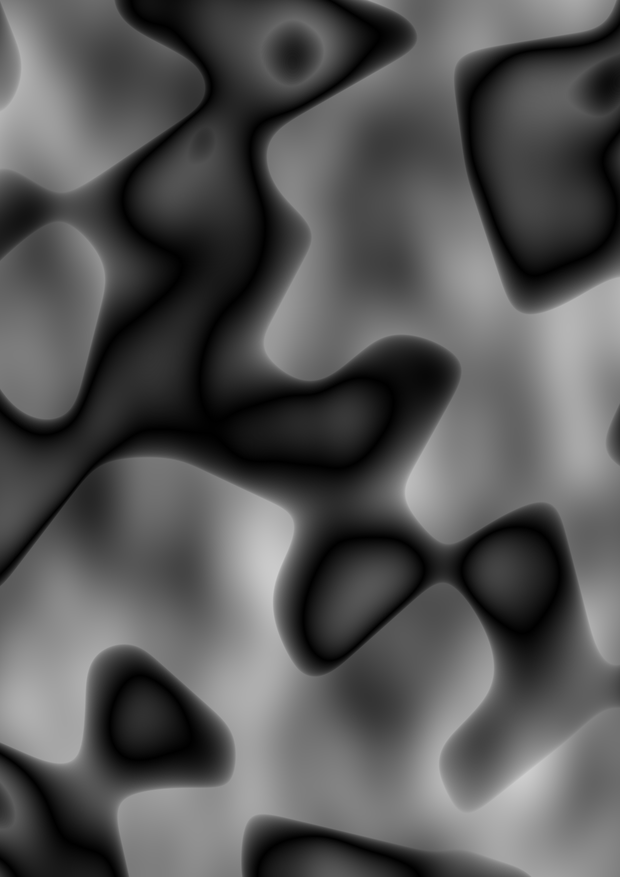

In [2]:
basename = "triangles"

scale = 4
# image_name = "images/moonface.png"
# image_name = "images/einstein.jpg"
# image_name = "images/david-bowie.jpg"
# image_name  = "images/scary_penguin.webp"
# image_name = "images/portrait_1.jpg"
image_name = "images/simplex_noise_difference_clouds.png"
# image_name = "images/dafoe.jpg"

image = PIL.Image.open(image_name)

image = image.resize((int(image.width / scale), int(image.height / scale)), PIL.Image.ANTIALIAS)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
# image = image.filter(PIL.ImageFilter.SMOOTH_MORE)
# image = image.filter(PIL.ImageFilter.CONTOUR)
# image = image.filter(PIL.ImageFilter.DETAIL)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE)
# image = image.filter(PIL.ImageFilter.EDGE_ENHANCE_MORE)
# image = image.filter(PIL.ImageFilter.SMOOTH_MORE)

# image = image.rotate(-90, expand=True)

image = image.convert("RGB")

width = image.width
height = image.height

display(image)

In [3]:
def move_to(gcode, x, y):
    gcode.move_to(
        ((x) / image.width) * (XMAX - XMIN) + XMIN,
        ((y) / image.height) * (YMAX - YMIN) + YMIN,
    )

In [4]:
point_cloud = []

pixel_step = 5

for x in range(0, image.width, pixel_step):
    for y in range(0, image.height, pixel_step):
        dx = uniform(-pixel_step / 2, pixel_step / 2)
        dy = uniform(-pixel_step / 2, pixel_step / 2)
        
        try:
            r, g, b = image.getpixel((x + dx, y + dy))
        except IndexError:
            continue
            
        intensity = ((255 - r) + (255 - g) + (255 - b)) / (255 * 3.0)
#         intensity = 1.0 - intensity
        
        if pow(intensity, 4) > uniform(0, 1):
            point_cloud.append((x + dx, y + dy))
            
print(len(point_cloud))

6404


In [5]:
min_dist = 0

kd_tree = KDTree(point_cloud)
close_points = kd_tree.query_pairs(min_dist)
print(len(close_points))

d = defaultdict(int)
for p1, p2 in close_points:
    d[p1] += 1
    d[p2] += 1

d_ = sorted(d.items(), key=itemgetter(1), reverse=True)

point_cloud = [x for index, x in enumerate(point_cloud) if index not in d or uniform(0, 1) > 0.5]
print(len(point_cloud))

0
6404


In [6]:
point_cloud = [x for x in point_cloud if uniform(0, 1) > 0.5]
print(len(point_cloud)) 

3190


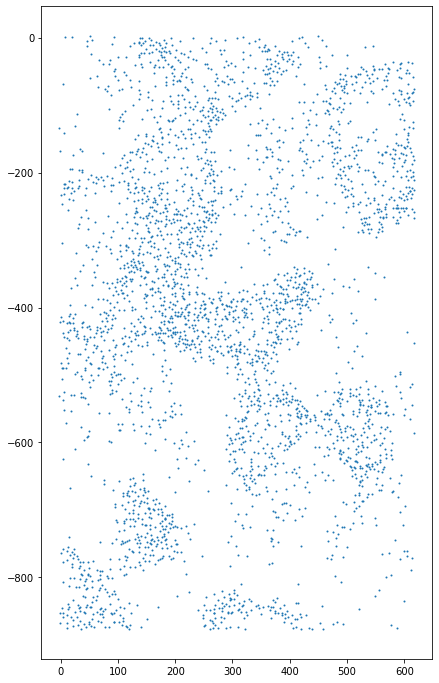

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 12))
plt.scatter(
    [x[0] for x in point_cloud], 
    [-x[1] for x in point_cloud],
    s=1,
)

In [8]:
def get_adjacent_edge(edges, vertex, eps=1e-4):
    for k, (v1, v2) in enumerate(edges):

        if dist(v1, vertex) < eps:
            return k, (v1, v2)
        
        if dist(v2, vertex) < eps:
            return k, (v2, v1)
        
    return None, None


def dist(a, b):
    if isinstance(a, (list, tuple)):
        a = np.array(a)
        
    if isinstance(b, (list, tuple)):
        b = np.array(b)
        
    return np.linalg.norm(a-b)

In [9]:
tri = Delaunay(point_cloud, furthest_site=False)
edges = []

for a, b, c in tri.simplices:
    p1 = point_cloud[a]
    p2 = point_cloud[b]
    p3 = point_cloud[c]
    
    zero = (0, 0)
    
    if dist(0, p1) < dist(0, p2):
        edges.append((p1, p2))
    else:
        edges.append((p2, p1))
    
    if dist(0, p1) < dist(0, p3):
        edges.append((p1, p3))
    else:
        edges.append((p3, p1))
        
    if dist(0, p2) < dist(0, p3):
        edges.append((p2, p3))
    else:
        edges.append((p3, p2))
        
print(len(edges))
edges = list(set(edges))
print(len(edges))

19071
9546


In [10]:
print(len(edges))
edges = [(v1, v2) for v1, v2 in edges if dist(v1, v2) > 4 and dist(v1, v2) < 50]
print(len(edges))

9546
8871


In [11]:
def plot_line(gcode, edges):
    v1, v2 =edges.pop(0)
    
    gcode.pen_up()
    move_to(gcode, *v1)
    
    gcode.pen_down()
    
    move_to(gcode, *v2)
    
    while True:
        k, v = get_adjacent_edge(edges, v2)
        if not k:
            break
        
        edges.pop(k)
        _,  v2 = v
        
        move_to(gcode, *v2)
        
    
    gcode.pen_up()

In [12]:
gcode = GCODE(basename, feedrate=1000)
# gcode.move_to_starting_position()
gcode.pen_down()
gcode.draw_boundaries()
gcode.pen_up()

gcode.pen_up()
gcode.move_to_mid_point()

In [ ]:
while len(edges) > 0:
    print(len(edges))
    plot_line(gcode, edges)

8871
8605
8232
8208
8194
8063
7964
7912
7828
7746
7721
7704
7619
7147
7099
7077


In [ ]:
gcode.pen_up()
gcode.move_to_starting_position()
gcode.flush()

In [ ]:
preview_png(basename, scale=3)